In [1]:
from __future__ import division
import math
import numpy as np
import numpy.random
import scipy as sp
import scipy.stats
from scipy.optimize import minimize_scalar
from permute.utils import hypergeom_conf_interval
import itertools

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# Tri-hypergeometric test using the diluted margin as the test statistic

We will sample individual ballots without replacement from a population of $N$ ballots, of which
$N_w$ ballots have a vote for $w$ but not for $\ell$, $N_\ell$ ballots have a vote for $\ell$ but not for $w$, and $N_u = N - N_w - N_\ell$ ballots have votes for both $w$ and $\ell$ or neither $w$ nor $\ell$, including undervotes and invalid ballots.
We might draw a simple random sample of $n$ ballots ($n$ fixed ahead of time), or we might draw 
sequentially, so the sample size $B$ could be random, including stopping rules that depend on the data.

Regardless, we assume that, conditional on the attained sample size $n$, the ballots are a simple random sample
of size $n$ from the $N$ ballots in the population.
Then, conditional on $B=n$, the joint distribution of
$(B_w, B_\ell, B_u)$ is tri-hypergeometric.

That is,

\begin{equation}
    \mathbb{P}_{N_w, N_\ell, N} \{ B_w = i, B_\ell = j \vert B=n \} = 
     \frac{ {N_w \choose i}{N_\ell \choose j}{N - N_w - N_\ell \choose n-i-j}}{{N \choose n}}.
\end{equation}

To test, we will condition on the event $B=n$. (In contrast, the BRAVO ballot-polling
method conditions on $B_w+B_\ell = m$;
we might instead consider conditioning on $B=n$ _and_ $B_w + B_\ell = m$.)
The test statistic will be the diluted sample margin, $D \equiv (B_w - B_\ell)/B$.
This is the sample difference in the number of ballots for the winner and for the loser, divided by the 
total number of ballots in the sample.
We want to test the compound hypothesis $N_w - N_\ell \le c$ against the compound alternative
$N_w - N_\ell > c$.
(To use Wald's Sequential Probability Ratio Test, we might pick a simple alternative instead, e.g.,
$N_w = V_w$ and $N_\ell = V_\ell$, the reported values, assuming $V_w - V_\ell > c$.)
Hence, we will reject for large values of $D$.
Conditional on $B=n$, the event $D = (B_w - B_\ell)/B = d$ is the event $B_w - B_\ell = nd$.

Suppose we observe $D=d$.
The $p$-value of the simple hypothesis that there are $N_w$ ballots with
a vote for $w$ but not for $\ell$, $N_\ell$ ballots with a vote for $\ell$ but not for $w$, and $N - N_w - N_\ell$ ballots with votes for both $w$ and $\ell$ or neither $w$ nor $\ell$ (including undervotes and
invalid ballots) is

\begin{equation}
   \mathbb{P}_{N_w, N_\ell, N} \left \{ D \geq d \vert B = n \right \} = 
   \mathbb{P}_{N_w, N_\ell, N}\{ B_w - B_\ell \geq nd \vert B = n \} =
   \sum_{(i, j) : i - j \geq nd; i+j \leq n; i, j\geq 0} 
         \frac{ {N_w \choose i}{N_\ell \choose j}{N - N_w - N_\ell \choose n-i-j}}{{N \choose n}}.
\end{equation}
Below we show empirically (but do not prove) that this tail probability is monotone increasing in $N_w$.

This expression can be simplified for numerical stability:

\begin{equation}
\frac{ {N_w \choose i}{N_\ell \choose j}{N - N_w - N_\ell \choose n-i-j}}{{N \choose n}} =
  \frac{ N_w! N_\ell! (N - N_w - N_\ell)! n! (N-n)!}
       {i! (N_w-i)! j! (N_\ell - j)! (n-i-j)! (N - N_w - N_\ell - n +i+j)! N!}
\end{equation}

The composite null hypothesis does not specify $N_w$ or $N_\ell$ separately, only that $N_w - N_\ell \le c$ for
some fixed, known $c$.
The (conditional) $p$-value of this composite hypothesis for $D=d$ is
\begin{equation}
  \max_{N_w, N_\ell \in \{0, 1, \ldots, N \}: N_w - N_\ell \le c, N_w + N_\ell \le N}
   \sum_{(i, j) : i - j \geq nd; i+j \leq n; i, j\geq 0} 
         \frac{ {N_w \choose i}{N_\ell \choose j}{N - N_w - N_\ell \choose n-i-j}}{{N \choose n}},
\end{equation}
wherever the summand is defined. 
(Equivalently, define ${N \choose M} \equiv 0$ if $M > N$, $M < 0$, or $N \le 0$.)
If the empirical result mentioned above is true, then finding the maximum is trivial; if not,
it is still at most a one-dimensional optimization problem.


## a mathematical digression
<span style="color: red;">We could condition on $B$ and $B_w + B_\ell$, which would give us a binomial... Worth trying? Any intuitive argument for why it would be better or worse? Might make using SPRT easier. PBS</span>


Suppose we condition on both $B$ and $B_w + B_\ell$.
Define $n_{w\ell} \equiv n_w + n_\ell$.
The $p$-value for the simple hypothesis stated above is now
\begin{align*}
   \mathbb{P}_{N_w, N_\ell, N} \left \{ D \geq d \vert B = n, B_w+B_\ell=n_{w\ell} \right \} &= 
   \mathbb{P}_{N_w, N_\ell, N}\{ B_w - B_\ell \geq nd \vert B = n,  B_w+B_\ell=n_{w\ell} \} \\
   &=  \sum_{ i \geq \frac{nd+n_{w\ell}}{2}} 
         \frac{ {N_w \choose i}{N_\ell \choose n_{w\ell}-i}{N - N_w - N_\ell \choose n-n_{w\ell}}}{{N \choose n}} \\
   &=   \frac{ {N - N_w - N_\ell \choose n-n_{w\ell}}}{{N \choose n}} \sum_{ i \geq \frac{nd+n_{w\ell}}{2}} 
         {N_w \choose i}{N_\ell \choose n_{w\ell}-i}.
\end{align*}

In [2]:
def diluted_margin_trihypergeometric(w, l, n, N_w, N_l, N):
    pvalue = 0
    N_u = N-N_w-N_l
    for ww in range(w-l, n+1):
        tmp = 0
        for ll in range(0, ww-w+l+1):
            if ww+ll > n:
                break
            else:
                tmp += sp.misc.comb(N_l, ll)*sp.misc.comb(N_u, n-ww-ll)
        pvalue += tmp * sp.misc.comb(N_w, ww)
    return pvalue/sp.misc.comb(N, n)


def diluted_margin_trihypergeometric2(w, l, n, N_w, N_l, N):
    pairs = itertools.product(range(n+1), range(n+1))
    pairs = itertools.filterfalse(lambda y: sum(y) > n, pairs)
    pairs = itertools.filterfalse(lambda y: y[0] - y[1] < (w-l), pairs)
    pvalue = 0
    N_u = N-N_w-N_l
    for p in pairs:
        if p[0] > N_w or p[1] > N_l or n-p[0]-p[1]>N_u:
            continue
        pvalue += sp.misc.comb(N_w, p[0])*sp.misc.comb(N_l, p[1])*sp.misc.comb(N_u, n-p[0]-p[1])
    return pvalue/sp.misc.comb(N, n)


def diluted_margin_trihyper_conditional(w, l, n, N_w, N_l, N):
    pvalue = 0
    delta = w-l
    n_wl = w+l
    N_u = N-N_w-N_l
    for ww in range(w, n+1):
        if ww > N_w or (n_wl - ww) > N_l or (n_wl - ww) < 0:
            continue
        pvalue += sp.misc.comb(N_w, ww)*sp.misc.comb(N_l, n_wl - ww)
    return pvalue*sp.misc.comb(N_u, n-n_wl)/sp.misc.comb(N, n)





In [3]:
# Unit tests

def test_find_pairs():
    # example: w=2, l=1, n=3
    pairs = itertools.product(range(3+1), range(3+1))
    pairs = itertools.filterfalse(lambda y: sum(y) > 3, pairs)
    pairs = itertools.filterfalse(lambda y: y[0] - y[1] < (2-1), pairs)
    expected_p = [(1, 0), (2, 0), (2, 1), (3, 0)]
    assert list(pairs)==expected_p
    
    # example: w=4, l=1, n=5
    pairs = itertools.product(range(5+1), range(5+1))
    pairs = itertools.filterfalse(lambda y: sum(y) > 5, pairs)
    pairs = itertools.filterfalse(lambda y: y[0] - y[1] < (4-1), pairs)
    expected_p = [(3, 0), (4, 0), (4, 1), (5, 0)]
    assert list(pairs)==expected_p
    
    
def test_diluted_margin_pvalue():
    # example 1: w=2, l=1, n=3, W=L=U=2
    t1 = 2*1*1/sp.misc.comb(6, 3) # w=1, l=0, u=2
    t2 = 1*1*2/sp.misc.comb(6, 3) # w=2, l=0, u=1
    t3 = 1*2*1/sp.misc.comb(6, 3) # w=2, l=1, u=0
    t4 = 0                        # w=3, l=0, u=0
    np.testing.assert_almost_equal(diluted_margin_trihypergeometric(2, 1, 3, 2, 2, 6), t1+t2+t3+t4)
    np.testing.assert_almost_equal(diluted_margin_trihypergeometric2(2, 1, 3, 2, 2, 6), t1+t2+t3+t4)
    
    # example 2: w=4, l=1, n=5, W=5, L=U=2
    t1 = sp.misc.comb(5, 3)*1*1/sp.misc.comb(9, 5) # w=3, l=0, u=2
    t2 = sp.misc.comb(5, 4)*1*2/sp.misc.comb(9, 5) # w=4, l=0, u=1
    t3 = sp.misc.comb(5, 4)*2*1/sp.misc.comb(9, 5) # w=4, l=1, u=0
    t4 = 1*1*1/sp.misc.comb(9, 5)                  # w=5, l=0, u=0
    np.testing.assert_almost_equal(diluted_margin_trihypergeometric(4, 1, 5, 5, 2, 9), t1+t2+t3+t4)
    np.testing.assert_almost_equal(diluted_margin_trihypergeometric2(4, 1, 5, 5, 2, 9), t1+t2+t3+t4)

def test_diluted_margin_trihyper_conditional():
    # example 1: w=2, l=1, n=3, W=L=U=2
    t3 = 1*2*1/sp.misc.comb(6, 3) # w=2, l=1, u=0
    t4 = 0                        # w=3, l=0, u=0
    np.testing.assert_almost_equal(diluted_margin_trihyper_conditional(2, 1, 3, 2, 2, 6), t3+t4)
    np.testing.assert_almost_equal(diluted_margin_trihyper_conditional(2, 1, 3, 2, 2, 6), t3+t4)

    # example 1: w=2, l=1, n=3, W=L=U=2
    hyper_prob = sp.stats.hypergeom.sf(2 - 1, 4, 2, 3) # decrement w by one to include the endpoint
    factor = sp.misc.comb(4, 3)*sp.misc.comb(2, 0)/sp.misc.comb(6, 3)
    np.testing.assert_almost_equal(diluted_margin_trihyper_conditional(2, 1, 3, 2, 2, 6), hyper_prob*factor)
    
    # example 2: w=4, l=1, n=5, W=5, L=U=2
    t3 = sp.misc.comb(5, 4)*2*1/sp.misc.comb(9, 5) # w=4, l=1, u=0
    t4 = 1*1*1/sp.misc.comb(9, 5)                  # w=5, l=0, u=0
    np.testing.assert_almost_equal(diluted_margin_trihyper_conditional(4, 1, 5, 5, 2, 9), t3+t4)
    np.testing.assert_almost_equal(diluted_margin_trihyper_conditional(4, 1, 5, 5, 2, 9), t3+t4)

    # example 2.5: w=4, l=1, n=5, W=5, L=U=2
    hyper_prob = sp.stats.hypergeom.sf(4 - 1, 7, 5, 5)
    factor = sp.misc.comb(7, 5)*sp.misc.comb(2, 0)/sp.misc.comb(9, 5)
    np.testing.assert_almost_equal(diluted_margin_trihyper_conditional(4, 1, 5, 5, 2, 9), hyper_prob*factor)
    
    # example 3: w=10, l=8, n=30, W=30, L=20, U=50
    hyper_prob = sp.stats.hypergeom.sf(10 - 1, 30 + 20, 30, 18)
    factor = sp.misc.comb(50, 18)*sp.misc.comb(50, 12)/sp.misc.comb(100, 30)
    np.testing.assert_almost_equal(diluted_margin_trihyper_conditional(10, 8, 30, 30, 20, 100), hyper_prob*factor)
    
test_find_pairs()
test_diluted_margin_pvalue()
test_diluted_margin_trihyper_conditional()

## Experiment 1 - few invalids

Testing the hypothesis $\pi_w - \pi_\ell \leq 0$ -- the same as testing whether the winner and the loser got exactly the same vote share. This is in blue.
Then we also test the hypotheses $N_w - N_\ell \leq 1$ (in green) and $N_w - N_\ell \leq 2$ (in red).

Let $N = 100$, $n=30$, $n_w = 15$, $n_\ell=10$, and $n_u = 5$.

Below, we plot the $p$-values for varying values of $N_w$.

The $p$-value is maximized for each contour at the largest possible value of $N_w$, and the contours have increasing $p$-values as the constant $N_w - N_\ell$ decreases.

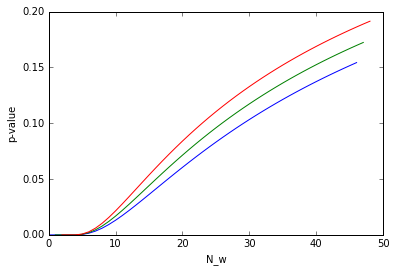

In [4]:
pvalues = np.zeros(47)
for B in range(47):
    pvalues[B] = diluted_margin_trihypergeometric(w=15, l=10, n=30, N_w=B, N_l=B, N=100)

pvalues2 = np.zeros(47)
for B in range(47):
    pvalues2[B] = diluted_margin_trihypergeometric(w=15, l=10, n=30, N_w=B+1, N_l=B, N=100)

pvalues3 = np.zeros(47)
for B in range(47):
    pvalues3[B] = diluted_margin_trihypergeometric(w=15, l=10, n=30, N_w=B+2, N_l=B, N=100)
    
plt.plot(range(47), pvalues, 'blue', 
         range(1,48), pvalues2, 'green',
         range(2,49), pvalues3, 'red')
plt.xlabel("N_w")
plt.ylabel("p-value")

Run the same experiment using the tri-hypergeometric which conditions on $B = n$ and $B_w+B_\ell = n_{w\ell}$.
This looks far more powerful but the $p$-value is no longer monotonic.

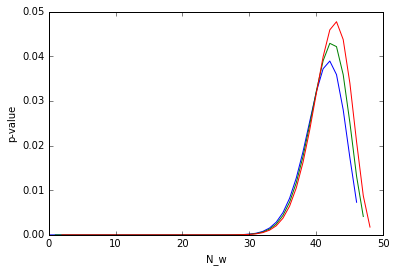

In [5]:
pvalues = np.zeros(47)
for B in range(47):
    pvalues[B] = diluted_margin_trihyper_conditional(w=15, l=10, n=30, N_w=B, N_l=B, N=100)

pvalues2 = np.zeros(47)
for B in range(47):
    pvalues2[B] = diluted_margin_trihyper_conditional(w=15, l=10, n=30, N_w=B+1, N_l=B, N=100)

pvalues3 = np.zeros(47)
for B in range(47):
    pvalues3[B] = diluted_margin_trihyper_conditional(w=15, l=10, n=30, N_w=B+2, N_l=B, N=100)
    
plt.plot(range(47), pvalues, 'blue', 
         range(1,48), pvalues2, 'green',
         range(2,49), pvalues3, 'red')
plt.xlabel("N_w")
plt.ylabel("p-value")

## Experiment 2 - many invalids

Testing the hypothesis $\pi_w - \pi_\ell \leq 0$ -- the same as testing whether the winner and the loser got exactly the same vote share. This is in blue.
Then we also test the hypotheses $N_w - N_\ell \leq 1$ (in green) and $N_w - N_\ell \leq 2$ (in red).

Let $N = 100$, $n=30$, $n_w = 8$, $n_\ell=7$, and $n_u = 15$.

Below, we plot the $p$-values for varying values of $N_w$.

The $p$-value is maximized for each contour at the largest possible value of $N_w$, and the contours have increasing $p$-values as the constant $N_w - N_\ell$ decreases.

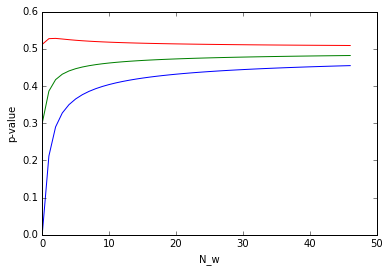

In [6]:
pvalues = np.zeros(47)
for B in range(47):
    pvalues[B] = diluted_margin_trihypergeometric(w=8, l=7, n=30, N_w=B, N_l=B, N=100)

pvalues2 = np.zeros(47)
for B in range(47):
    pvalues2[B] = diluted_margin_trihypergeometric(w=8, l=7, n=30, N_w=B+1, N_l=B, N=100)

pvalues3 = np.zeros(47)
for B in range(47):
    pvalues3[B] = diluted_margin_trihypergeometric(w=8, l=7, n=30, N_w=B+2, N_l=B, N=100)
    
plt.plot(range(47), pvalues, 'blue', 
         range(47), pvalues2, 'green',
         range(47), pvalues3, 'red')
plt.xlabel("N_w")
plt.ylabel("p-value")

Run the same experiment using the tri-hypergeometric which conditions on $B = n$ and $B_w+B_\ell = n_{w\ell}$.
This looks far more powerful but the $p$-value is no longer monotonic.

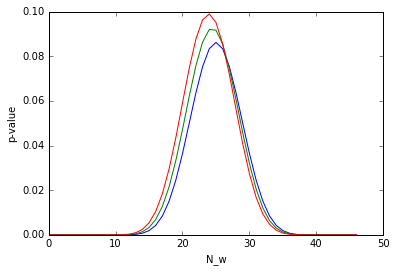

In [7]:
pvalues = np.zeros(47)
for B in range(47):
    pvalues[B] = diluted_margin_trihyper_conditional(w=8, l=7, n=30, N_w=B, N_l=B, N=100)

pvalues2 = np.zeros(47)
for B in range(47):
    pvalues2[B] = diluted_margin_trihyper_conditional(w=8, l=7, n=30, N_w=B+1, N_l=B, N=100)

pvalues3 = np.zeros(47)
for B in range(47):
    pvalues3[B] = diluted_margin_trihyper_conditional(w=8, l=7, n=30, N_w=B+2, N_l=B, N=100)
    
plt.plot(range(47), pvalues, 'blue', 
         range(47), pvalues2, 'green',
         range(47), pvalues3, 'red')
plt.xlabel("N_w")
plt.ylabel("p-value")

## Experiment 3

Testing the hypothesis $\pi_w - \pi_\ell = 0.1$ -- the same as $N_w - N_\ell = 0.1N$.

Let $N = 100$, $n=30$, $n_w = 15$, $n_\ell=10$, and $n_u = 5$.

Plot both diluted margin tri-hypergeometric $p$-values on the same grid. Clearly, the extra conditioning provides more power.

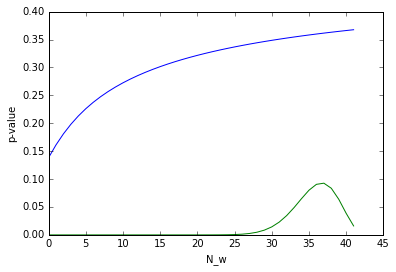

In [8]:
pvalues = np.zeros(42)
for B in range(42):
    pvalues[B] = diluted_margin_trihypergeometric(w=15, l=10, n=30, N_w=0.1*100 + B, N_l=B, N=100)
    
pvalues2 = np.zeros(42)
for B in range(42):
    pvalues2[B] = diluted_margin_trihyper_conditional(w=15, l=10, n=30, N_w=0.1*100 + B, N_l=B, N=100)
    
    
plt.plot(range(42), pvalues, 'blue', 
         range(42), pvalues2, 'green')
plt.xlabel("N_w")
plt.ylabel("p-value")

# Hypergeometric test

Conditional on $B_{w\ell} = n_w+n_\ell$, the $p$-value is

\begin{equation}
\mathbb{P} \{ d \geq \frac{n_w - n_\ell}{n} | B_{w\ell} = n_w+n_\ell \} = \mathbb{P}\{ B_w - B_\ell \geq n_w - n_\ell | B_{w\ell} = n_w+n_\ell \} 
   = \sum_{(i, j) : i - j \geq n_w-n_\ell; i+j = n_w+n_\ell; i, j\geq 0} \frac{ {N_w \choose i}{N_\ell \choose j}}{{N_{w\ell} \choose n_w+n_\ell}}.
\end{equation}

Under the null hypothesis, $N_w - N_\ell \leq c$ for specified $c$, but neither parameter value is known.

We show empirically, but not analytically, below that the tail probability is monotone increasing in $N_w$.

Actually compute the $p$-value as

\begin{equation}
\mathbb{P} \{ d \geq \frac{n_w - n_\ell}{n} | B_{w\ell} = n_w+n_\ell \} = \mathbb{P}\{ B_w - B_\ell \geq n_w - n_\ell | B_{w\ell} = n_w+n_\ell \} 
   = \sum_{(i, j) : i - j \geq n_w-n_\ell; i+j = n_w+n_\ell; i, j\geq 0} \frac{ {N_\ell+c \choose i}{N_\ell \choose j}}{{2N_\ell+c \choose n_w+n_\ell}}.
\end{equation}

In [9]:
def diluted_margin_hypergeometric(w, l, N_w, N_l):
    """
    Conduct hypergeometric test
    
    H_0: N_w - N_l <= c
    H_1: N_w - N_l > c
    
    Parameters
    ----------
    w : int
        number of votes for w in sample
    l : int
        number of votes for l in sample
    N_w : int
        total number of votes for w in the population *under the null*
    N_l : int
        total number of votes for l in the population *under the null*
    Returns
    -------
    int
        probability, under the null, of observing a number of votes for w 
        greater than or equal to input w in the sample
    """
    delta = w-l
    n = w+l
    pairs = itertools.product(range(n+1), range(n+1))
    pairs = itertools.filterfalse(lambda y: sum(y) != n, pairs)
    pairs = itertools.filterfalse(lambda y: y[0] - y[1] < delta, pairs)
    
    pvalue = 0
    for p in pairs:
        pvalue += sp.stats.hypergeom.pmf(p[0], N_w + N_l, N_w, p[0]+p[1])
    return pvalue


def diluted_margin_hypergeometric2(w, l, N_w, N_l):
    pvalue = 0
    delta = w-l
    n = w+l
    for ww in range(int((delta+n) / 2), n+1):
        pvalue += sp.stats.hypergeom.pmf(ww, N_w + N_l, N_w, n)
    return pvalue

In [10]:
# Unit tests

def test_find_pairs_hyper():
    # example: w=2, l=1, n=3
    pairs = itertools.product(range(3+1), range(3+1))
    pairs = itertools.filterfalse(lambda y: sum(y) != 3, pairs)
    pairs = itertools.filterfalse(lambda y: y[0] - y[1] < (2-1), pairs)
    expected_p = [(2, 1), (3, 0)]
    assert list(pairs)==expected_p
    
    # example: w=4, l=1, n=5
    pairs = itertools.product(range(5+1), range(5+1))
    pairs = itertools.filterfalse(lambda y: sum(y) != 5, pairs)
    pairs = itertools.filterfalse(lambda y: y[0] - y[1] < (4-1), pairs)
    expected_p = [(4, 1), (5, 0)]
    assert list(pairs)==expected_p
    
    
def test_diluted_margin_pvalue_hyper():
    # example 1: w=2, l=1, n=3, W=L=U=2
    t3 = 1*2/sp.misc.comb(4, 3)   # w=2, l=1, u=0
    t4 = 0                        # w=3, l=0, u=0
    np.testing.assert_almost_equal(diluted_margin_hypergeometric(2, 1, 2, 2), t3+t4)
    np.testing.assert_almost_equal(diluted_margin_hypergeometric2(2, 1, 2, 2), t3+t4)
    
    # example 1: w=4, l=1, n=5, W=5, L=U=2
    t3 = sp.misc.comb(5, 4)*2/sp.misc.comb(7, 5)   # w=4, l=1, u=0
    t4 = 1*1/sp.misc.comb(7, 5)                    # w=5, l=0, u=0
    np.testing.assert_almost_equal(diluted_margin_hypergeometric(4, 1, 5, 2), t3+t4)
    np.testing.assert_almost_equal(diluted_margin_hypergeometric2(4, 1, 5, 2), t3+t4)
    
test_find_pairs_hyper()
test_diluted_margin_pvalue_hyper()

## Experiment 1 - few invalids

Testing the hypothesis $\pi_w - \pi_\ell \leq 0$ -- the same as testing whether the winner and the loser got exactly the same vote share. This is in blue.
Then we also test the hypotheses $N_w - N_\ell \leq 1$ (in green) and $N_w - N_\ell \leq 2$ (in red).

Let $N = 100$, $n=30$, $n_w = 15$, $n_\ell=10$, and $n_u = 5$.

Below, we plot the $p$-values for varying values of $N_w$.

The $p$-value is maximized for each contour at the largest possible value of $N_w$, and the contours have increasing $p$-values as the constant $N_w - N_\ell$ decreases.

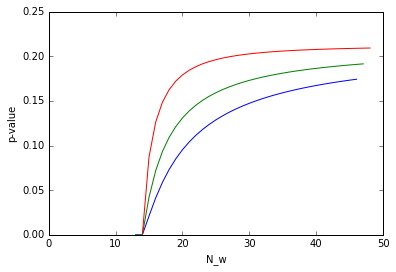

In [11]:
pvalues = np.zeros(47)
for B in range(1,47):
    pvalues[B] = diluted_margin_hypergeometric(w=15, l=10, N_w=B, N_l=B)

pvalues2 = np.zeros(47)
for B in range(1,47):
    pvalues2[B] = diluted_margin_hypergeometric(w=15, l=10, N_w=B+1, N_l=B)

pvalues3 = np.zeros(47)
for B in range(1,47):
    pvalues3[B] = diluted_margin_hypergeometric(w=15, l=10, N_w=B+2, N_l=B)
    
plt.plot(range(47), pvalues, 'blue', 
         range(1, 47+1), pvalues2, 'green',
         range(2, 47+2), pvalues3, 'red')
plt.xlabel("N_w")
plt.ylabel("p-value")

# Comparing tri-hypergeometric and plain hypergeometric

## Experiment 1

Testing the hypothesis $\pi_w - \pi_\ell \leq 2/N$.
The tri-hypergeometric $p$-values are in blue and the hypergeometric $p$-values are in green, for increasing values of the parameter $N_w$.

Let $N = 100$, $n=30$, $n_w = 15$, $n_\ell=10$, and $n_u = 15$.

The $p$-value is maximized for each contour at the largest possible value of $N_w$, and the contours have increasing $p$-values as the constant $N_w - N_\ell$ decreases.

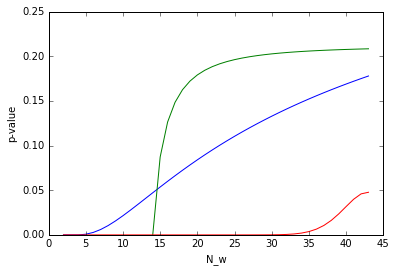

In [12]:
pvalues = np.zeros(42)
for B in range(42):
    pvalues[B] = diluted_margin_trihypergeometric(w=15, l=10, n=30, N_w=B+2, N_l=B, N=100)
    
pvalues2 = np.zeros(42)
for B in range(42):
    pvalues2[B] = diluted_margin_hypergeometric(w=15, l=10, N_w=B+2, N_l=B)
    
pvalues3 = np.zeros(42)
for B in range(42):
    pvalues3[B] = diluted_margin_trihyper_conditional(w=15, l=10, n=30, N_w=B+2, N_l=B, N=100)
    
plt.plot(range(2, 42+2), pvalues, 'blue', 
         range(2, 42+2), pvalues2, 'green',
         range(2, 42+2), pvalues3, 'red')
plt.xlabel("N_w")
plt.ylabel("p-value")

# Comparing tri-hypergeometric and plain hypergeometric

## Experiment 2

Testing the hypothesis $N_w - N_\ell \leq 2$.
The tri-hypergeometric $p$-values are in blue and the hypergeometric $p$-values are in green, for increasing values of the parameter $N_w$.

Let $N = 100$, $n=30$, $n_w = 8$, $n_\ell=7$, and $n_u = 15$.

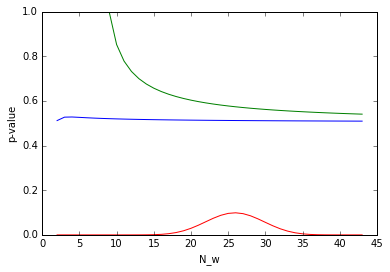

In [13]:
pvalues = np.zeros(42)
for B in range(42):
    pvalues[B] = diluted_margin_trihypergeometric(w=8, l=7, n=30, N_w=B+2, N_l=B, N=100)
    
pvalues2 = np.zeros(42)
for B in range(42):
    pvalues2[B] = diluted_margin_hypergeometric(w=8, l=7, N_w=B+2, N_l=B)

pvalues3 = np.zeros(42)
for B in range(42):
    pvalues3[B] = diluted_margin_trihyper_conditional(w=8, l=7, n=30, N_w=B+2, N_l=B, N=100)
    
plt.plot(range(2, 42+2), pvalues, 'blue', 
         range(2, 42+2), pvalues2, 'green',
         range(2, 42+2), pvalues3, 'red')
plt.xlabel("N_w")
plt.ylabel("p-value")

## Takeaways

* Not consistent whether the hypergeometric or tri-hypergeometric has more power. Perhaps hypergeometric actually is better!
* The $p$-value of each test is maximized at the largest value of $N_w$. Thus, to construct a conservative test, take $N_w + N_\ell = N - n_u$, where $n_u$ is the number of invalid ballots or ballots for other candidates *in the sample*. This gives a crude upper bound on how many valid ballots for the winner or loser exist in the population.
* The p-values seem to be **increasing in c, the null hypothesis margin**. Thus, when testing a null hypothesis, the most conservative test lies on the boundary $N_w - N_\ell = c$, with $N_w$ as large as possible.